In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.optim import Adam
from tqdm import tqdm
from dotenv import load_dotenv

from transformers import RobertaModel, RobertaTokenizer
from torch.utils.data.sampler import WeightedRandomSampler

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
torch.cuda.is_available()

True

In [3]:
load_dotenv()

True

In [4]:
wandb.login()

wandb: Currently logged in as: afifaniks. Use `wandb login --relogin` to force relogin


True

In [4]:
def load_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [5]:
def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame, minimum_contribution = 0) -> pd.DataFrame:
    developers = df["assignees"].value_counts()
    df = df[df["assignees"].notna()]
    filtered_developers = developers.index[developers >= minimum_contribution]
    df = df[df["assignees"].isin(filtered_developers)]

    df["text"] = df.apply(lambda x: "Title: " + str(x["issue_title"]) + "\nDescription: " + str(x["issue_body"]), axis=1)
    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    df["owner_id"] = pd.factorize(df["assignees"])[0]

    return df

In [6]:
data_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/openj9_topic_kmeans_issues.csv"

df = load_dataframe(data_path)
df = prepare_dataframe(df, minimum_contribution=5)
df = clean_data(df)

/tmp/ipykernel_1307532/2741451366.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')


In [7]:
df.head()

,Unnamed: 0.1,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,assignees,labels,topic_id,topic_label,text,owner_id
0,0,0,1000,https://github.com/eclipse-openj9/openj9/issue...,OpenJ9 JDK8 builds fail to run Apache Spark du...,Attempting to run Spark 2.2.1 results in the f...,closed,ymanton,pshipton,blocker,0,Building OpenJ9,Title: OpenJ9 JDK8 builds fail to run Apache S...,0
1,1,1,10003,https://github.com/eclipse-openj9/openj9/issue...,jdknext (16) sanity.functional failures,From PR testing of https://github.com/ibmrunti...,closed,pshipton,keithc-ca,"comp:vm, jdk16",11,Java compilation issues,Title: jdknext (16) sanity.functional failures...,1
4,4,4,1001,https://github.com/eclipse-openj9/openj9/issue...,MathLoadTest+LockingLoadTest Systemtests faili...,Issue as follows - need to determine correct b...,closed,Mesbah-Alam,Mesbah-Alam,question,2,Java Heap Space Errors,Title: MathLoadTest+LockingLoadTest Systemtest...,2
6,6,6,10022,https://github.com/eclipse-openj9/openj9/issue...,Remove remnants of JVMPI from JIT,The JIT still has remnants of JVMPI support wh...,closed,0xdaryl,alexey-anufriev,"help wanted, good first issue, comp:jit",1,JIT performance optimization,Title: Remove remnants of JVMPI from JIT\nDesc...,3
7,7,7,10025,https://github.com/eclipse-openj9/openj9/issue...,Build failure using Docker image due to git re...,I am following the instructions provided at ht...,closed,darshitpp,keithc-ca,"comp:build, userRaised",12,Docker build failures,Title: Build failure using Docker image due to...,1


In [8]:
len(df["assignees"].unique())

95

In [9]:
df.head()

,Unnamed: 0.1,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,assignees,labels,topic_id,topic_label,text,owner_id
0,0,0,1000,https://github.com/eclipse-openj9/openj9/issue...,OpenJ9 JDK8 builds fail to run Apache Spark du...,Attempting to run Spark 2.2.1 results in the f...,closed,ymanton,pshipton,blocker,0,Building OpenJ9,Title: OpenJ9 JDK8 builds fail to run Apache S...,0
1,1,1,10003,https://github.com/eclipse-openj9/openj9/issue...,jdknext (16) sanity.functional failures,From PR testing of https://github.com/ibmrunti...,closed,pshipton,keithc-ca,"comp:vm, jdk16",11,Java compilation issues,Title: jdknext (16) sanity.functional failures...,1
4,4,4,1001,https://github.com/eclipse-openj9/openj9/issue...,MathLoadTest+LockingLoadTest Systemtests faili...,Issue as follows - need to determine correct b...,closed,Mesbah-Alam,Mesbah-Alam,question,2,Java Heap Space Errors,Title: MathLoadTest+LockingLoadTest Systemtest...,2
6,6,6,10022,https://github.com/eclipse-openj9/openj9/issue...,Remove remnants of JVMPI from JIT,The JIT still has remnants of JVMPI support wh...,closed,0xdaryl,alexey-anufriev,"help wanted, good first issue, comp:jit",1,JIT performance optimization,Title: Remove remnants of JVMPI from JIT\nDesc...,3
7,7,7,10025,https://github.com/eclipse-openj9/openj9/issue...,Build failure using Docker image due to git re...,I am following the instructions provided at ht...,closed,darshitpp,keithc-ca,"comp:build, userRaised",12,Docker build failures,Title: Build failure using Docker image due to...,1


In [10]:
print(len(df))

3365


<Axes: ylabel='assignees'>

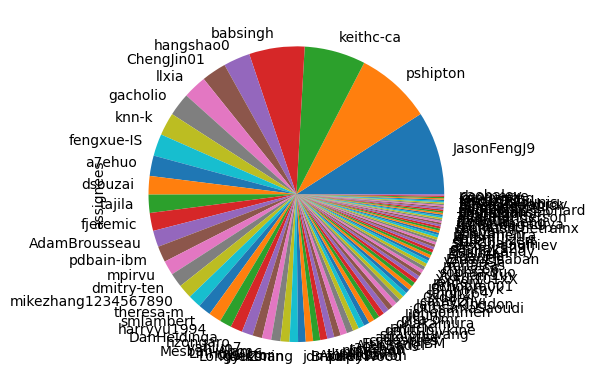

In [11]:
df["assignees"].value_counts().plot(kind="pie")

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
np.random.seed(112)
X_train, X_test = train_test_split(df, test_size=0.2)

print(len(X_train["assignees"].unique()), len(X_test["assignees"].unique()))

95 89


In [14]:
# counts = np.bincount(X_train["owner_id"])
# labels_weights = 1. / counts
# weights = labels_weights[X_train["owner_id"]]
# sampler = WeightedRandomSampler(weights, len(weights))

In [15]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.labels = [label for label in df['owner_id']]
        self.texts = [self.tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [16]:
class LBTLikeClassifier(nn.Module):
    def __init__(self, model_name: str, output_size, num_filters=256, bert_layers=4, embed_size=768, dropout = 0.1) -> None:
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(model_name, output_hidden_states=True)
        filter_sizes = [3, 4, 5, 6]
        self.num_filters = num_filters
        self.bert_layers = bert_layers
        self.convs1 = nn.ModuleList([nn.Conv2d(self.bert_layers, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters + embed_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids, attention_mask = attention_mask)
        hidden_states = x["hidden_states"][-self.bert_layers:]
        pooler_output = x["pooler_output"]
        x = torch.stack(hidden_states, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = torch.cat([pooler_output, x], 1)
        x = self.dropout(x)
        logit = self.fc1(x)

        return self.relu(x)


In [17]:
class Classifier(nn.Module):
    def __init__(self, model_name: str, output_size, embed_size=1024, dropout = 0.1) -> None:
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(model_name, output_hidden_states=True)
        filter_sizes = [3, 4, 5, 6]
        num_filters = 256
        self._tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.convs1 = nn.ModuleList([nn.Conv2d(4, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, output_size)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids, attention_mask = attention_mask)[2][-4:]
        x = torch.stack(x, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)  

        return self.relu(logit)
    
    def tokenizer(self) -> RobertaTokenizer:
        return self._tokenizer


In [18]:
def train(model, tokenizer, train_data, val_data, learning_rate, epochs, out_file, run, batch_size = 15):
    train, val = Dataset(train_data, tokenizer), Dataset(val_data, tokenizer)

    wandb.init(
        # Set the project where this run will be logged
        project="triager_x", 
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name=f"experiment_{run}", 
        # Track hyperparameters and run metadata
        config={
        "learning_rate": learning_rate,
        "architecture": "Roberta-CNN",
        "dataset": "openj9",
        "epochs": epochs,
    })
    

    train_dataloader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=True
        # sampler=sampler
    )
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    best_loss = float("inf")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        print("Using CUDA...")
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        print(f"Epoch: {epoch_num}")
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_id = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        val_loss = total_loss_val / len(val_data)

        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}"
        print(log)

        wandb.log({
            "train_acc": total_acc_train / len(train_data), 
            "train_loss": total_loss_train / len(train_data),
            "val_acc": total_acc_val / len(val_data),
            "val_loss": total_loss_val / len(val_data)
            })

        if val_loss < best_loss:
            print("Found new best model. Saving weights...")
            torch.save(model.state_dict(), out_file)
            best_loss = val_loss
    
    wandb.finish()

EPOCHS = 50
num_classes = len(df["assignees"].unique())
model = Classifier("roberta-base", num_classes, 768)
tokenizer = model.tokenizer()
LR = 1e-6

train(model, tokenizer, X_train, X_test, LR, EPOCHS, "no_strat_imbalanced_5.pt", "no_strat_imbalanced_5")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

wandb: Currently logged in as: afifaniks. Use `wandb login --relogin` to force relogin


Using CUDA...
Epoch: 0


100%|██████████| 180/180 [51:04<00:00, 17.02s/it]


Epochs: 1 | Train Loss:  0.295                 | Train Accuracy:  0.058                 | Val Loss:  0.280                 | Val Accuracy:  0.089
Found new best model. Saving weights...
Epoch: 1


 62%|██████▏   | 111/180 [31:22<19:40, 17.11s/it]

In [ ]:
import numpy as np
from sklearn.metrics import top_k_accuracy_score

# Load Saved Model

In [ ]:
num_classes = len(df["assignees"].unique())
model = Classifier("roberta-base", num_classes, 768)
model.load_state_dict(torch.load("/home/mdafifal.mamun/notebooks/triagerX/no_strat_imbalanced_5.pt"))
model = model.cuda()
tokenizer = model.tokenizer()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import random

y_preds = []

for i in range(len(X_test)):
    # rand = random.randint(0, len(df_val))
    dx = X_test.iloc[i]

    data = tokenizer(dx["text"], padding='max_length', max_length = 512, truncation=True)
    ids, mask = data["input_ids"], data["attention_mask"]

    id = torch.tensor([ids]).cuda()
    m = torch.tensor([mask]).cuda()

    g = nn.Softmax(dim=1)

    with torch.no_grad():
        y_pred = g(model(id, m))
        
    y_preds.append(y_pred)

In [ ]:
y_true = X_test["owner_id"].to_numpy()

In [ ]:
sorted(X_test["owner_id"].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

In [ ]:
y_numpy = []

for y in y_preds:
    y_numpy.append(y.cpu().numpy())

In [ ]:
y_preds = np.array(y_numpy)[:,0,:]

In [ ]:
len(y_true)

1021

In [ ]:
top_k_accuracy_score(y_true, y_preds, k=3)

ValueError: Number of classes in 'y_true' (46) not equal to the number of classes in 'y_score' (47).You can provide a list of all known classes by assigning it to the `labels` parameter.

In [ ]:
top_k_accuracy_score(y_true, y_preds, k=5)

0.7874632713026445

Weighted Sampler Stratified, Minimum 5

    Top5 = 84%
    Top3 = 71%

Unweighted Sampler Stratified, Minimum 5

    Top5 = 79%
    Top3 = 71%

Unweighted Sampler Stratified, Minimum 10

    Top5 = 80%
    Top3 = 73%